In [112]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [113]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [114]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 32
control_energy_reg = 0#1e-3#1e-6 ### regularization on maximum control energy
u_max = 1000 # does not do anything currently
thres = 0.1#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [115]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [116]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 0.3], [0, 0.3]],
                    [[0.6, 0.9], [0.7, 0.9]]])
region  = np.array([[[0, 1.], [0, 1.]]])
custom_pdf = functools.partial(pdf, regions=region)

In [117]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 10000)


calulcated sigma: 0.05


torch.Size([256, 32, 32])
model: tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5999e-42,
          2.9007e-43, 1.5414e-44],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5730e-38,
          1.2714e-39, 6.7784e-41],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5354e-35,
          3.6667e-36, 1.9552e-37],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.2227e+00,
          4.8834e+00, 4.8169e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.6293e+00,
          8.6097e+00, 8.8512e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.4905e+00,
          1.0306e+01, 1.0810e+01]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6657e-33,
          3.1506e-35, 3.9309e-37],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4239e-30,
          2.6947e-32, 3.3641e-34],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.0423e-28,
          1.5231e-29, 1.9030e-31],
         ...,
         [0.0000e+00, 4.0638e-44, 1.7508e-40, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [2000/2000], Loss: 0.061380, lr: 0.001000


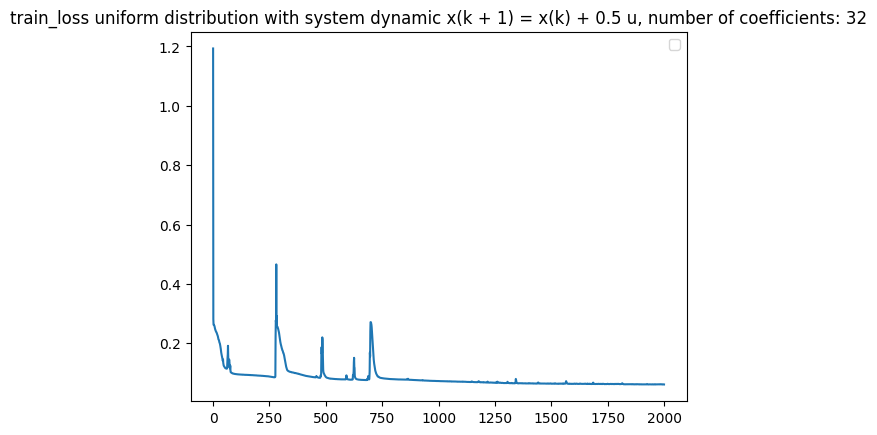

Training Complete!


In [118]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 2000  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    if avg_loss < 0.011 and not decreased:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [125]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)
#print(criterion.c)

torch.Size([1, 32, 32])
model: tensor([[[5.9158e-03, 1.6288e-02, 2.9594e-02,  ..., 3.4618e-02,
          1.2521e-02, 2.9871e-03],
         [2.2929e-02, 6.3130e-02, 1.1468e-01,  ..., 1.0788e-01,
          3.9022e-02, 9.3098e-03],
         [5.8614e-02, 1.6138e-01, 2.9313e-01,  ..., 2.2179e-01,
          8.0260e-02, 1.9164e-02],
         ...,
         [1.9661e-03, 1.2797e-02, 5.4944e-02,  ..., 4.4523e-01,
          2.4162e-01, 8.6493e-02],
         [7.7702e-04, 5.0589e-03, 2.1732e-02,  ..., 2.3823e-01,
          1.2929e-01, 4.6284e-02],
         [2.0263e-04, 1.3196e-03, 5.6768e-03,  ..., 8.4081e-02,
          4.5634e-02, 1.6336e-02]]], grad_fn=<CopySlices>) target: tensor([[0.0636, 0.0991, 0.1281,  ..., 0.1394, 0.1189, 0.0834],
        [0.0969, 0.1492, 0.1898,  ..., 0.2121, 0.1775, 0.1223],
        [0.1231, 0.1877, 0.2358,  ..., 0.2648, 0.2168, 0.1467],
        ...,
        [0.1658, 0.2394, 0.2861,  ..., 0.2721, 0.2310, 0.1622],
        [0.1429, 0.2031, 0.2394,  ..., 0.2259, 0.1905, 0.133

tensor(0.0604, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


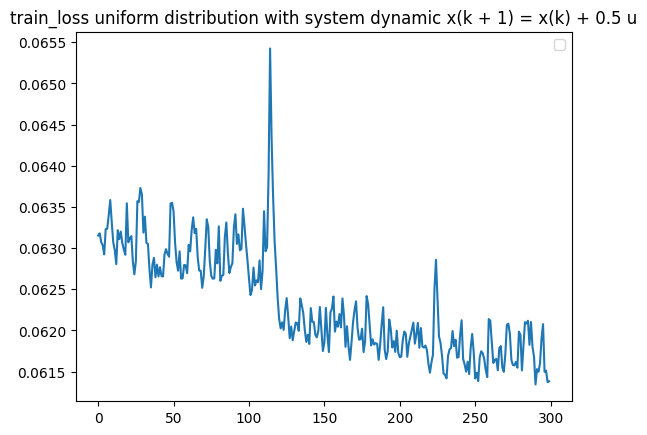

Training Complete!


In [126]:
plt.plot(train_loss[-300:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

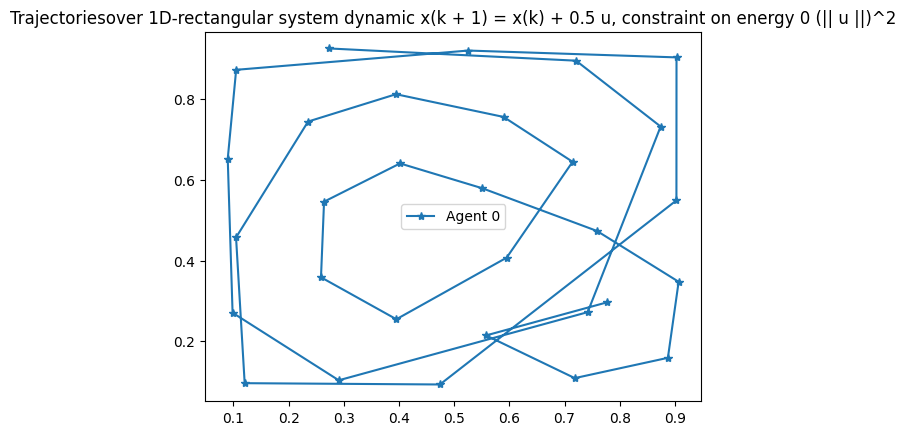

torch.Size([1, 32, 32])
model: tensor([[[5.8083e-03, 1.6274e-02, 3.0090e-02,  ..., 3.3739e-02,
          1.2249e-02, 2.9329e-03],
         [2.2313e-02, 6.2517e-02, 1.1557e-01,  ..., 1.0621e-01,
          3.8561e-02, 9.2341e-03],
         [5.6533e-02, 1.5840e-01, 2.9279e-01,  ..., 2.2059e-01,
          8.0122e-02, 1.9201e-02],
         ...,
         [2.6991e-03, 1.7010e-02, 7.0732e-02,  ..., 4.4218e-01,
          2.3890e-01, 8.5139e-02],
         [1.1758e-03, 7.4164e-03, 3.0853e-02,  ..., 2.3601e-01,
          1.2752e-01, 4.5444e-02],
         [3.3835e-04, 2.1343e-03, 8.8793e-03,  ..., 8.3084e-02,
          4.4893e-02, 1.5999e-02]]], grad_fn=<CopySlices>) target: tensor([[0.0636, 0.0991, 0.1281,  ..., 0.1394, 0.1189, 0.0834],
        [0.0969, 0.1492, 0.1898,  ..., 0.2121, 0.1775, 0.1223],
        [0.1231, 0.1877, 0.2358,  ..., 0.2648, 0.2168, 0.1467],
        ...,
        [0.1658, 0.2394, 0.2861,  ..., 0.2721, 0.2310, 0.1622],
        [0.1429, 0.2031, 0.2394,  ..., 0.2259, 0.1905, 0.133

tensor(0.0610, grad_fn=<AddBackward0>)

In [140]:
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)


In [141]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_sigma_005_region_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_sigma_005_region_0-0.3.0.6-0.9_multiple_Agentsaa9b9fdf.pth


In [123]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

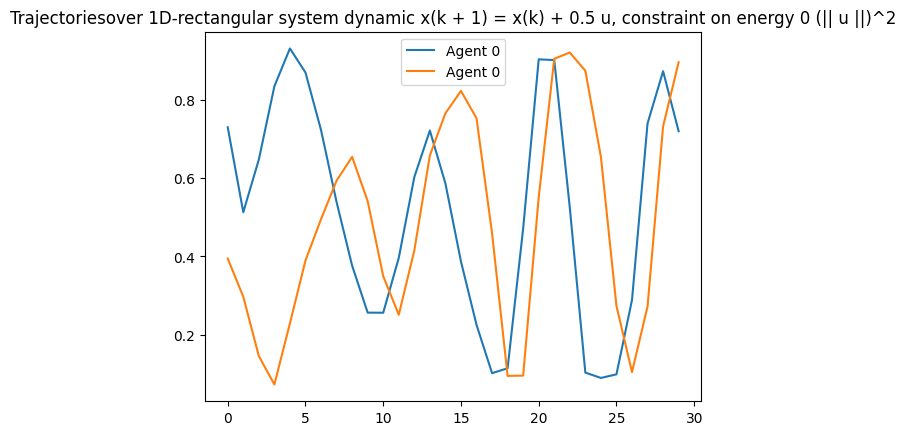

torch.Size([1, 32, 32])
model: tensor([[[0.0082, 0.0225, 0.0410,  ..., 0.0380, 0.0141, 0.0034],
         [0.0290, 0.0799, 0.1452,  ..., 0.1166, 0.0431, 0.0105],
         [0.0678, 0.1867, 0.3394,  ..., 0.2359, 0.0873, 0.0213],
         ...,
         [0.0307, 0.0640, 0.0902,  ..., 0.4436, 0.2439, 0.0884],
         [0.0068, 0.0144, 0.0216,  ..., 0.2336, 0.1284, 0.0466],
         [0.0010, 0.0022, 0.0040,  ..., 0.0812, 0.0446, 0.0162]]],
       grad_fn=<CopySlices>) target: tensor([[0.0636, 0.0991, 0.1281,  ..., 0.1394, 0.1189, 0.0834],
        [0.0969, 0.1492, 0.1898,  ..., 0.2121, 0.1775, 0.1223],
        [0.1231, 0.1877, 0.2358,  ..., 0.2648, 0.2168, 0.1467],
        ...,
        [0.1658, 0.2394, 0.2861,  ..., 0.2721, 0.2310, 0.1622],
        [0.1429, 0.2031, 0.2394,  ..., 0.2259, 0.1905, 0.1332],
        [0.0973, 0.1361, 0.1589,  ..., 0.1530, 0.1283, 0.0894]])


tensor(0.0649, grad_fn=<AddBackward0>)

In [124]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)